# Demo 3 - Uso de modelo pré treinado YOLO (You Only Look Once)

### Detecção de objetos em tempo real com Yolo e OpenCV

### Prof. Dr. José Ahirton Batista Lopes Filho

In [ ]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

#Exibição na mesma tela do Jupyter
%matplotlib inline

from io import BytesIO
from IPython.display import clear_output, Image, display
import PIL

plt.style.use('seaborn')
sns.set_style("whitegrid", {'axes.grid' : False})

### 1. Arquivos no Drive/Colab

Carregando imagens previamente existentes.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Carregando as configurações e pesos

Carregando as informações do modelo Yolo, que são: os labels, provenientes de um conjunto de dados fornecido pelo Coco, os pesos, que é o classificador já treinado, pronto para uso e um arquivo final de configurações.

In [ ]:
# Carregar os labels do conjunto de dados Coco
label_path = os.path.sep.join(["drive/My Drive/data", "coco.names"])
labels = open(label_path).read().strip().split("\n")

# Atribuir a cada label uma cor diferente (randômica)
np.random.seed(42)
cores = np.random.randint(0, 255, size=(len(labels), 3), dtype="uint8")

# Definir caminho dos arquivos de pesos e configuração
pesos_path = os.path.sep.join(["drive/My Drive/pesos", "yolov3.weights"])
config_path = os.path.sep.join(["drive/My Drive/cfg", "yolov3.cfg"])

# Carregar a rede
net = cv2.dnn.readNetFromDarknet(config_path, pesos_path)

Classificadores SSD (Single Shot Detection) possuem dois tipos de calibração básico. O primeiro é o limiar de confiança, quanto maior este limiar menor será o número de objetos identificados, pois ficará mais restrito aos objetos somente com maior confiança. O segundo, o NMS (Non-Maxima Supression), ou supressão não máxima, que é um parâmetro para controlar a sensibilidade em imagens com baixa luminosidade.

In [ ]:
conf_threshold = 0.5
nms_threshold = 0.5

A função a seguir irá identificar os objetos em uma imagem (ou frame) e desenhar os *bounding boxes* nela, retornando a mesma imagem.

In [ ]:
def identificar_objetos(frame):
    
    (H, W) = frame.shape[:2]

    ln = net.getLayerNames()
    ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]

    # Normalizando a imagem (fator de escala, tamanho, RGB/BGR)
    blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416),  swapRB=True, crop=False)
    net.setInput(blob)
    layerOutputs = net.forward(ln)

    # Inicialização das bounding boxes
    boxes = []
    confidences = []
    classIDs = []

    for output in layerOutputs:
        for detection in output:
            # Extração de pontuação e confiança
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            # Filtrar somente o que for maior que o limiar de confiança
            if confidence > conf_threshold:
                
                # Definição do bounding box encontrado

                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    # Aplicação do NMS (Non-Maxima Suppression) para eliminar overlapping de bounding boxes
    
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

    if len(idxs) > 0:
        for i in idxs.flatten():
            # Após o filtro por NMS, desenhar os bounding boxes
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            color = [int(c) for c in cores[classIDs[i]]]
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            text = "{}: {:.4f}".format(labels[classIDs[i]], confidences[i])
            cv2.putText(frame, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            
    return frame

Vamos fazer rum teste com uma imagem estática.

In [ ]:
imagem_inferencia = cv2.imread("drive/My Drive/imagens/theoffice.jpg")
imagem_inferencia = cv2.cvtColor(imagem_inferencia, cv2.COLOR_BGR2RGB)
(width, height) = imagem_inferencia.shape[:2]

Text(0.5, 1.0, 'Imagem Inferida')

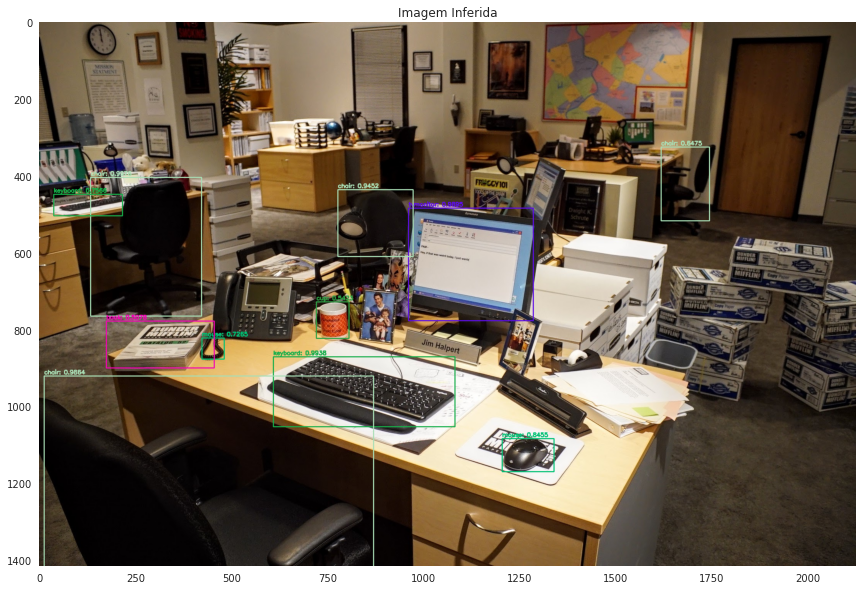

In [ ]:
imagem = identificar_objetos(imagem_inferencia)

imagem_example = cv2.cvtColor(imagem, cv2.COLOR_RGB2BGR)
cv2.imwrite("drive/My Drive/theoffice_result.png", imagem_example)

plt.figure(figsize=(20,10))
plt.imshow(imagem)
plt.title("Imagem Inferida")

O classificador também funciona com vídeos. Há duas formas de trabalharmos. A primeira é gravarmos um vídeo e processar posteriormente um novo vídeo. A segunda, é classificar em tempo real os objetos, mas neste caso se perdem muitos frames pois o CPU não é capaz de classificar adequadamente em tempo real.

## 3. Detecção em Vídeo

A seguir, criaremos um algoritmo que irá ler frame a frame de um vídeo, processar e escrever outro vídeo com as classificações e bounding boxes desenhados.

In [ ]:
#cam.release()
cam = cv2.VideoCapture("drive/My Drive/videos/shibuya_crossing.avi")
writer = None
try:
    while(True):
        
        is_capturing, imagem = cam.read()
        
        if is_capturing:
            
            frame = identificar_objetos(imagem)
           
            if writer is None:
                # initialize our video writer
                fourcc = cv2.VideoWriter_fourcc(*"MJPG")
                writer = cv2.VideoWriter("drive/My Drive/shibuya_crossing_result.avi", fourcc, 30, (frame.shape[1], frame.shape[0]), True)

            # write the output frame to disk
            writer.write(frame)
           
        else:
            break
        
except KeyboardInterrupt:
    cam.release()
    print("Interrompido")